In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Define constants
mass = 39.95*1.68*10**(-27)
epsilon = 119.8/1.381*10**(-23)
sigma = 3.405 #angstrom
Electric_Charge = 1
Epsilon_0 = 8.85*10**(-12)*sigma*epsilon*Electric_Charge**2
N_Particles = 108

#User input
rho = 0.3 #units of sigma**-3, N*m/L^3
Temperature = 3.0
Box_Size = (N_Particles/rho)**(1/3)
Lattice_Size = Box_Size/3
#Box_Size = 100
#Lattice_Size = 3.12354
Particle_Charge = -1*Electric_Charge
E_Field = 0.2


Timestep = 0.001
Iterations = 15
Dimensions = 3

In [3]:
#Functions

def Force(A_Position,B_Position):
    Sequence_Polarity = np.array(A_Position>B_Position)*2 -1
    Image_Polarity = np.array(np.power((A_Position-B_Position),2)>(Box_Size/2)**(2))
    Distances = (Image_Polarity*Box_Size-np.abs(A_Position-B_Position))
    Distance = np.sum(np.power(Distances,2))**(0.5)
    Lennard_Jones_pot = 4*(Distance**(-6) - Distance**(-12))
    Total_Force = 4*(6/(Distance)**(7) - 12/(Distance)**(13))
    Directions = Distances*Sequence_Polarity
    Forces = (Directions/Distance)*Total_Force
    Forces[2] += Particle_Charge*E_Field
    return Forces, Lennard_Jones_pot, Distance, Total_Force

#Maybe write to file multiple times and get values from this file to get <n(r)>
#Or run code again and use Distance_List1, Distance_List2 etc
Distance_List = []
def Dist_Pair_Corr(Distance):
    Distance_List.append(Distance)

Delta_r = Lattice_Size/20
Pair_Corr_Bins = np.arange(0, 3*Lattice_Size/2, Delta_r)
Pair_Corr_r_List = []
#Calculated for each [r, r+delta_r]
#Distance here is every value of Pair_Corr_Bins
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Bin_Size)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

Pressure_LJ_Pot_list = []
def Average_LJ_Pot(Distance, Total_Force):
    Pressure_LJ_Pot = Distance*Total_Force
    Pressure_LJ_Pot_list.append(Pressure_LJ_Pot)
    return Pressure_LJ_Pot_list

In [4]:
# Loop to initialize the particles' positions, velocities, energies

E_kin_initial = np.array([0.0])
E_pot_initial = np.array([0.0])


#Positions of atoms
unit_cell = np.array([[Lattice_Size/2,Lattice_Size/2,Lattice_Size/2],[Lattice_Size,Lattice_Size,Lattice_Size/2],
                      [Lattice_Size,Lattice_Size/2,Lattice_Size],[Lattice_Size/2,Lattice_Size,Lattice_Size]])

#Write all x, y, z positions and x, y, z velocities to this array
pos = np.zeros((N_Particles,6))

#Number of cells
Nx = 3
Ny = 3
Nz = 3
Step = 0
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            pos[Step:Step+4,:3] = (unit_cell + np.tile([i,j,k],4).reshape(4,3))
            Velocities = np.zeros((4,3))
            for l in range(int(np.size(unit_cell)/3)):
                vx = np.random.normal(0, np.sqrt(Temperature))
                vy = np.random.normal(0, np.sqrt(Temperature))
                vz = np.random.normal(0, np.sqrt(Temperature))
                Velocities[l,:] = np.array([vx,vy,vz])
                
            
            pos[Step:Step+4,3:] = Velocities
            Step += int(np.size(unit_cell)/3)

In [5]:
#Calculate positions, velocities, energies, forces etc for multiple timesteps
Historic_Positions = np.zeros((N_Particles,Dimensions,Iterations))
Historic_Velocities = np.zeros((N_Particles,Dimensions,Iterations))

Positions = pos[:,:3]
Velocities = pos[:,3:]
Historic_Positions[:,:,0] = Positions
Historic_Velocities[:,:,0] = Velocities

Energy = np.zeros((Iterations,4))
Energy[:,2] = 0.5*Lattice_Size**3*Epsilon_0*E_Field**2
#kin, pot, electric, total

for t in range(Iterations-1):
    Energy[t,0] = np.sum(0.5*Velocities[:,:]**2)  
    if t == 0:
        Energy[t,1] = 0
    else:
        Energy[t,1] = -np.sum(Pot_En)
    Energy[t,3] = Energy[t,0] + Energy[t,1] + Energy[t,2]
    Forces = np.zeros((N_Particles,Dimensions))
    Pot_En = np.zeros((N_Particles,Dimensions))
    for i  in range(N_Particles):
        for j in range(N_Particles):
            if (i != j):
                Added_Forces, LJ_En, Distance, Total_Force = Force(Positions[i,:],Positions[j,:])
                Forces[i] += Added_Forces
                Pot_En[i] += LJ_En
                if i < j and t in range(Iterations-10, Iterations-5):
                    Dist_Pair_Corr(Distance)
                    Pressure_Value = Average_LJ_Pot(Distance, Total_Force)
                
    Positions = (Historic_Positions[:,:,t] + Velocities*Timestep + Forces*(Timestep**2)/2)%Box_Size
    Historic_Positions[:,:,t+1] = Positions
    if (t>0):
        Velocities = Historic_Velocities[:,:,t-1] + (Historic_Forces+Forces)*(Timestep/2)
        Historic_Velocities[:,:,t] = Velocities
    Historic_Forces = Forces
    
    #print(Distance)
#     plt.scatter(Positions[:,0],Positions[:,1])
#     plt.xlim(0,L)
#     plt.ylim(0,L)
#     plt.show()
#     clear_output(wait=True)

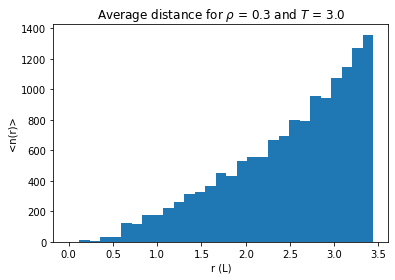

In [6]:
Avg_n = plt.hist(Distance_List, bins = Pair_Corr_Bins)
plt.xlabel('r (L)')
plt.ylabel('<n(r)>')
plt.title(r'Average distance for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()

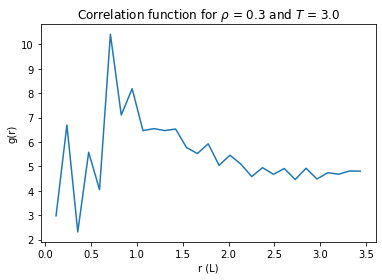

In [7]:
Pair_Corr_r_List = []
def Pair_Corr_function(Average_n, Distance_r):
    Pair_Corr_r = 2*(Lattice_Size*3)**3/((N_Particles*(N_Particles-1)))*Average_n/(4*np.pi*Distance_r**2*Delta_r)
    Pair_Corr_r_List.append(Pair_Corr_r)
    return Pair_Corr_r_List

for Average_n, Distance_r in zip(Avg_n[0], Pair_Corr_Bins[1:]):
    Pair_Corr_function(Average_n, Distance_r)


plt.plot(Pair_Corr_Bins[1:], Pair_Corr_r_List)
plt.xlabel('r (L)')
plt.ylabel('g(r)')
plt.title(r'Correlation function for $\rho$ = {}'.format(rho) + r' and $T$ = {}'.format(Temperature))
plt.show()

In [8]:
#Pressure
#To get average over multiple initial conditions, save the Pressure_Value_Total ssomewhere
# and run the simulation multiple times
Pressure_Value_Total = np.sum(Pressure_Value)/len(Pressure_Value)
print(Pressure_Value_Total)
Pressure = 1 - (3*N_Particles)*0.5*Pressure_Value_Total
print(Pressure)

-251393245864.28287
40725705830014.83


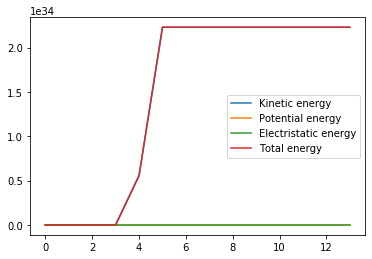

In [9]:
plt.plot(Energy[0:-1,0], label = 'Kinetic energy')
plt.plot(Energy[0:-1,1], label = 'Potential energy')
plt.plot(Energy[0:-1,2], label = 'Electristatic energy')
plt.plot(Energy[0:-1,3], label = 'Total energy')
plt.legend()

<class 'numpy.ndarray'>


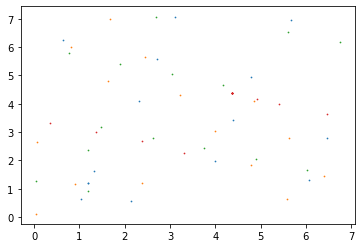

In [10]:
plt.scatter(Historic_Positions[0,1,:], Historic_Positions[0,2,:], s = 0.5)
plt.scatter(Historic_Positions[1,1,:], Historic_Positions[1,2,:], s = 0.5)
plt.scatter(Historic_Positions[2,1,:], Historic_Positions[2,2,:], s = 0.5)
plt.scatter(Historic_Positions[107,1,:], Historic_Positions[107,2,:], s = 0.5)

#plt.xlim(0,5)

Historic_Positions[:,:,0]

print(type(Historic_Positions))

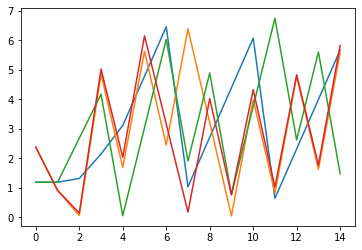

In [11]:
plt.plot(Historic_Positions[0,1,:])
plt.plot(Historic_Positions[1,1,:])
plt.plot(Historic_Positions[2,1,:])
plt.plot(Historic_Positions[3,1,:])

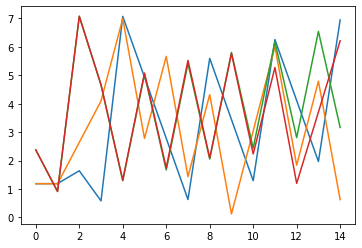

In [12]:
plt.plot(Historic_Positions[0,2,:])
plt.plot(Historic_Positions[1,2,:])
plt.plot(Historic_Positions[2,2,:])
plt.plot(Historic_Positions[3,2,:])